In [1]:
from RNN_QSR import *

cuda:0


In [2]:
class PE2D(nn.Module):
    def __init__(self, d_model, Lx,Ly,device,n_encode=None):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(Lx*Ly, d_model)
        
        if type(n_encode)==type(None):
            n_encode=3*d_model//4
        for pos in range(Lx*Ly):
            x=pos//Ly
            y=pos%Ly
            # Only going to fill 3/4 of the matrix so the
            # occupation values are preserved
            for i in range(0, n_encode, 4):
                
                #x direction encoding
                pe[pos, i] = \
                math.sin(x / (10000 ** ((2 * i)/n_encode)))
                pe[pos, i + 1] = \
                math.cos(x / (10000 ** ((2 * (i + 1))/n_encode)))
                #y direction encoding
                pe[pos, i+2] = \
                math.sin(y / (10000 ** ((2 * i)/n_encode)))
                pe[pos, i + 3] = \
                math.cos(y / (10000 ** ((2 * (i + 1))/n_encode)))
                
        self.pe = pe.unsqueeze(0).to(device)
        self.L=Lx*Ly
    
    def forward(self, x):
        return x + self.pe[:,:self.L,:]

In [3]:
class SlowTransformer(Sampler):
    def __init__(self,Lx,Ly,device=device,Nh=128,decoder=False,dropout=0.0,num_layers=3, **kwargs):
        super(SlowTransformer, self).__init__(device=device)
        
        self.pe = PE2D(Nh, Lx,Ly,device)
        
        if decoder:
            #Decoder only transformer
            self.decoder_layer = nn.TransformerDecoderLayer(d_model=Nh, nhead=8, dropout=dropout)
            self.transformer = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        else:
            #Encoder only transformer
            #misinterperetation on encoder made it so this code does not work
            self.encoder_layer = nn.TransformerEncoderLayer(d_model=Nh, nhead=8, dropout=dropout)
            self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        
        self.lin = nn.Sequential(
                nn.Linear(Nh,Nh),
                nn.ReLU(),
                nn.Linear(Nh,1),
                nn.Sigmoid()
            )
        
        
        self.set_mask(Lx*Ly)
        self.to(device)
        
    def set_mask(self, L):
        # take the log of a lower triangular matrix
        self.L=L
        self.mask = torch.log(torch.tril(torch.ones(L,L))).to(device)
        self.pe.L=L

    def forward(self, input):
        # input is shape [B,L,1]
        # add positional encoding to get shape [B,L,Nh]
        if input.shape[1]!=self.L:
            self.set_mask(input.shape[1])
        
        input=self.pe(input).transpose(1,0)
        output = self.transformer(input,self.mask)
        output = self.lin(output.transpose(1,0))
        return output
    
    
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        #Input should have shape [B,L,1]
        B,L,one=input.shape
        
        #first prediction is with the zero input vector
        data=torch.zeros([B,L,one],device=self.device)
        #data is the input vector shifted one to the right, with the very first entry set to zero instead of using pbc
        data[:,1:,:]=input[:,:-1,:]
        
        #real is going to be a set of actual values
        real=input
        #and pred is going to be a set of probabilities
        #if real[i]=1 than you multiply your conditional probability by pred[i]
        #if real[i]=0 than you multiply by 1-pred[i]
        
        #probability predictions may be done WITH gradients
        #with torch.no_grad():
        
        pred = self.forward(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
        #this is the sum you see in the cell above
        #add 1e-10 to the prediction to avoid nans when total=0
        logp=torch.sum(torch.log(total+1e-10),dim=1).squeeze(1)
        return logp
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        
        #Sample set will have shape [B,L,1]
        #need one extra zero batch at the start for first pred hence input is [N,L+1,1] 
        input = torch.zeros([B,L+1,1],device=self.device)
        
        #self.set_mask(L)
        #sampling can be done without gradients
        with torch.no_grad():
          for idx in range(1,L+1):
            #run the rnn on shape [B,1,1]   
            #encode the input to the proper shape
            encoded_input = input[:,:idx,:]+self.pe.pe[:,:idx,:]
                        
            #Get transformer output
            output = self.transformer(encoded_input.transpose(1,0),self.mask[:idx,:idx])
            #if probs[i]=1 then there should be a 100% chance that sample[i]=1
            #if probs[i]=0 then there should be a 0% chance that sample[i]=1
            #stands that we generate a random uniform u and take int(u<probs) as our sample
            probs=self.lin(output.transpose(1,0)[:,-1,:])
            sample = (torch.rand([B,1],device=device)<probs).to(torch.float32)
            input[:,idx,:]=sample
        #input's first entry is zero to get a predction for the first atom
        return input[:,1:,:]

In [4]:
class FastTransformer(SlowTransformer):
    
    def next_attn(_,tgt,layer):
        """Calculates self attention with tgt and the last elem of tgt
        Inputs: 
            tgt - Tensor of shape [L+1,B,1]
            layer - TransformerDecoderLayer
        Outputs:
            Tensor of shape [1,B,1]
        """
        src = tgt[-1:, :, :]

        # self attention part
        src2 = layer.self_attn(
            src,#only do attention with the last elem of the sequence
            tgt,
            tgt,
            attn_mask=None,  # not needed because we only care about the last token
            key_padding_mask=None,
        )[0]
        #straight from torch transformer encoder code
        src = src + layer.dropout1(src2)
        src = layer.norm1(src)
        src2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(src))))
        src = src + layer.dropout2(src2)
        src = layer.norm2(src)
        return src
    
    def next_with_cache(self,tgt,cache=None):
        """Efficiently calculates the next output of a transformer given the input sequence and 
        cached intermediate layer encodings of the input sequence
        
        Inputs:
            tgt - Tensor of shape [L+1,B,1]
            cache - Tensor of shape ?
            
        Outputs:
            output - Tensor of shape [?,B,1]
            new_cache - Tensor of shape ?
        """
        output = tgt
        new_token_cache = []
        #go through each layer and apply self attention only to the last input
        for i, layer in enumerate(self.transformer.layers):
            output = self.next_attn(output,layer)
            new_token_cache.append(output)
            if cache is not None:
                #layers after layer 1 need to use a cache of the previous layer's output on each input
                output = torch.cat([cache[i], output], dim=0)

        #update cache with new output
        if cache is not None:
            new_cache = torch.cat([cache, torch.stack(new_token_cache, dim=0)], dim=1)
        else:
            new_cache = torch.stack(new_token_cache, dim=0)

        return output, new_cache
    
    def set_mask(self, L):
        # take the log of a lower triangular matrix
        self.L=L
        self.mask = torch.log(torch.tril(torch.ones(L,L))).to(device)
        self.pe.L=L
        self.pe_t = self.pe.pe.transpose(1,0)
    
    
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        #return (torch.rand([B,L,1],device=device)<0.5).to(torch.float32)
        #Sample set will have shape [B,L,1]
        #need one extra zero batch at the start for first pred hence input is [L+1,B,1] 
        #transformers don't do batch first so to save a bunch of transpose calls 
        input = torch.zeros([L+1,B,1],device=self.device)
        #self.set_mask(L)
        
        cache=None
        with torch.no_grad():
          for idx in range(1,L+1):
            #run the rnn on shape [B,1,1]   
            #encode the input to the proper shape
            encoded_input = input[:idx,:,:]+self.pe_t[:idx,:,:]
                        
            #Get transformer output
            output,cache = self.next_with_cache(encoded_input,cache)
            #if probs[i]=1 then there should be a 100% chance that sample[i]=1
            #if probs[i]=0 then there should be a 0% chance that sample[i]=1
            #stands that we generate a random uniform u and take int(u<probs) as our sample
            probs=self.lin(output[-1,:,:])
            sample = (torch.rand([B,1],device=device)<probs).to(torch.float32)
            input[idx,:,:]=sample
        #input's first entry is zero to get a predction for the first atom
        #print(".",end="")
        return input.transpose(1,0)[:,1:,:]

In [5]:
#Settings
op=Opt()
Lx=8
op.L=Lx*Lx
op.Nh=64
op.lr=5e-4
op.Q=1
op.K=32
op.USEQUEUE=0
#op.apply(sys.argv[1:])
op.B=op.K*op.Q
print(op)

L                             			64
Q                             			1
K                             			32
B                             			32
TOL                           			0.15
M                             			0.96875
USEQUEUE                      			0
NLOOPS                        			1
hamiltonian                   			Rydberg
steps                         			12000
dir                           			out
Nh                            			64
lr                            			0.0005



In [6]:
trainsformer = FastTransformer(Lx,Lx,Nh=op.Nh,num_layers=2)
sampleformer= FastTransformer(Lx,Lx,Nh=op.Nh,num_layers=2)
beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
trainsformer.parameters(), 
lr=op.lr, 
betas=(beta1,beta2)
)


In [7]:
print(sum (p.numel () for p in trainsformer.parameters ()))

847681


In [8]:
#op.steps=4000
op.dir="TFF"

if op.USEQUEUE:
    queue_train(op,(trainsformer,sampleformer,optimizer))
else:
    print("Training. . .")
    reg_train(op,(trainsformer,optimizer))
    #reg_train(op,(super(FastTransformer, trainsformer),optimizer))

Training. . .
Output folder path established
-0.40522 64
1,1.53|92,-0.33|185,-0.32|278,-0.34|370,-0.36|463,-0.35|555,-0.38|648,-0.42|740,-0.40|832,-0.41|925,-0.41|1034,-0.41|1149,-0.40|1263,-0.41|1378,-0.41|1494,-0.41|1608,-0.41|1722,-0.41|1837,-0.41|1951,-0.41|2066,-0.41|2164,-0.40|2257,-0.41|2351,-0.41|2444.6738176345825 12000


In [11]:
print("Batch size 32:")

t=time.time()
for x in range(50):
    super(FastTransformer, trainsformer).sample(32,op.L)
print("old: ",time.time()-t)

t=time.time()
for x in range(50):
    trainsformer.sample(32,op.L)
print("new: ",time.time()-t)

print("Batch size 320:")

t=time.time()
for x in range(50):
    super(FastTransformer, trainsformer).sample(320,op.L)
print("old: ",time.time()-t)

t=time.time()
for x in range(50):
    trainsformer.sample(320,op.L)
print("new: ",time.time()-t)




Batch size 32:
old:  3.984227418899536
new:  3.6998283863067627
Batch size 320:
old:  25.44533944129944
new:  4.284188985824585


torch.Size([32, 64, 1])


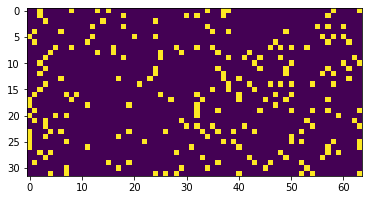

torch.Size([32, 64, 1])


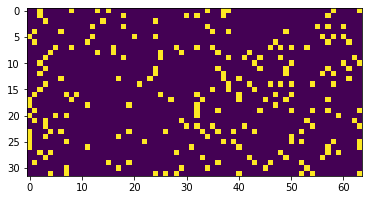

tensor(0., device='cuda:0')


In [9]:
if True:
    #trainsformer = FastTransformer(Lx,Lx,Nh=op.Nh,num_layers=2)
    torch.random.manual_seed(7)
    s = trainsformer.sample(op.B,op.L)
    print(s.shape)
    plt.imshow(s[:,:,0].cpu())
    plt.show()
    torch.random.manual_seed(7)
    s2 = super(FastTransformer, trainsformer).sample(op.B,op.L)
    print(s2.shape)
    plt.imshow(s2[:,:,0].cpu())
    plt.show()
    print(torch.sum(abs(s2-s)))

In [9]:
# train a gru
op.dir="GRU"
trainrnn,optimizer=new_rnn_with_optim("GRU",459,lr=op.lr)
print(sum (p.numel () for p in trainrnn.parameters ()))
reg_train(op,(trainrnn,optimizer))

847774
Output folder path established
-0.40522 64


KeyboardInterrupt: 

In [8]:
Lx=4
op.L=Lx*Lx
op.dir="GRU"
trainrnn,optimizer=new_rnn_with_optim("GRU",320,lr=op.lr)
print(sum (p.numel () for p in trainrnn.parameters ()))
reg_train(op,(trainrnn,optimizer))

413121
Output folder path established
-0.45776822 16
0,2.01|5,-0.38|10,-0.42|15,-0.44|20,-0.45|25,-0.45|31,-0.45|36,-0.45|41,-0.46|46,-0.45|51,-0.46|56,-0.45|61,-0.45|66,-0.46|71,-0.46|76,-0.46|82,-0.46|87,-0.44|92,-0.45|97,-0.46|102,-0.46|107,-0.45|112,-0.45|117,-0.46|122.32494974136353 12000


In [7]:



#op.steps=4000
op.dir="TF"


if op.USEQUEUE:
    queue_train(op,(trainsformer,sampleformer,optimizer))
else:
    print("Training. . .")
    reg_train(op,(trainsformer,optimizer))

Training. . .
Output folder path established
-0.40522 64
0,2.38|133,-0.31|267,-0.30|400,-0.35|536,-0.37|670,-0.40|804,-0.41|938,-0.41|1072,-0.41|1206,-0.40|1340,-0.41|1474,-0.41|1609,-0.41|1743,-0.41|1877,-0.41|2011,-0.41|2146,-0.41|2285,-0.42|2426,-0.41|2560,-0.40|2695,-0.41|2829,-0.41|2963,-0.41|3097,-0.41|3231.5833308696747 12000


In [8]:
torch.arange(4*4).reshape([4,4,1]) + torch.ones([1,4,4])

tensor([[[ 1.,  1.,  1.,  1.],
         [ 2.,  2.,  2.,  2.],
         [ 3.,  3.,  3.,  3.],
         [ 4.,  4.,  4.,  4.]],

        [[ 5.,  5.,  5.,  5.],
         [ 6.,  6.,  6.,  6.],
         [ 7.,  7.,  7.,  7.],
         [ 8.,  8.,  8.,  8.]],

        [[ 9.,  9.,  9.,  9.],
         [10., 10., 10., 10.],
         [11., 11., 11., 11.],
         [12., 12., 12., 12.]],

        [[13., 13., 13., 13.],
         [14., 14., 14., 14.],
         [15., 15., 15., 15.],
         [16., 16., 16., 16.]]])

In [9]:
pe = PE2D(40,6,6,torch.device('cpu')).pe
print(pe.shape,pe.max())

torch.Size([1, 36, 40]) tensor(1.)


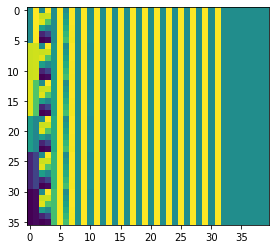

In [10]:
plt.imshow(pe[0])

In [11]:
torch.zeros([1,2,3]).transpose(1,0)

tensor([[[0., 0., 0.]],

        [[0., 0., 0.]]])